<a href="https://colab.research.google.com/github/RosetheOnly/Credit-Decisioning/blob/main/CreditScoremodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import zipfile
import os

# === Unzip the datasets if needed ===
def unzip_file(zip_path):
    if zip_path.endswith(".zip"):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall("/content")

unzip_file("/content/AEP_hourly.csv.zip")
unzip_file("/content/PS_20174392719_1491204439457_log.csv.zip")
# Personal finance file is already CSV, not zipped

# === Load the data ===
personal = pd.read_csv("/content/Personal_Finance_Dataset.csv")
paysim = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")
energy = pd.read_csv("/content/AEP_hourly.csv")

print("✅ Datasets loaded")

# === Standardize Dates ===
personal['Date'] = pd.to_datetime(personal['Date'], errors='coerce')
paysim['step'] = pd.to_timedelta(paysim['step'], unit='h')
paysim['Date'] = pd.to_datetime("2020-01-01") + paysim['step']
energy['Datetime'] = pd.to_datetime(energy['Datetime'], errors='coerce')

# === Simulate 100 User IDs ===
users = [f'user_{i}' for i in range(1, 101)]
personal['user_id'] = np.random.choice(users, size=len(personal))
paysim['user_id'] = np.random.choice(users, size=len(paysim))
energy['user_id'] = np.random.choice(users, size=len(energy))

# === Calculate Balance for Personal Finance Data ===
personal['Balance'] = personal.groupby('user_id')['Amount'].cumsum()


# === Personal Finance Features ===
pf_features = personal.groupby('user_id').agg({
    'Amount': ['sum', 'mean'],
    'Balance': 'mean'
})
pf_features.columns = ['pf_total_amount', 'pf_avg_amount', 'pf_avg_balance']

# === PaySim Features ===
mpesa_features = paysim.groupby('user_id').agg({
    'amount': ['sum', 'mean', 'count'],
    'isFraud': 'sum'
})
mpesa_features.columns = ['mpesa_total', 'mpesa_avg', 'mpesa_count', 'fraud_count']

# === Energy Features ===
energy_features = energy.groupby('user_id')['AEP_MW'].agg(['mean', 'std'])
energy_features.columns = ['energy_avg', 'energy_std']

# === Combine all features ===
combined = pf_features.join(mpesa_features).join(energy_features)
combined.reset_index(inplace=True)
combined.fillna(0, inplace=True)

# === Export combined dataset ===
combined.to_csv("/content/combined_credit_features.csv", index=False)
print("✅ Combined dataset saved to: /content/combined_credit_features.csv")

✅ Datasets loaded
✅ Combined dataset saved to: /content/combined_credit_features.csv


In [17]:
from sklearn.preprocessing import StandardScaler

# Load combined dataset
df = pd.read_csv("/content/combined_credit_features.csv")

# Optionally drop outliers
df = df[df['pf_total_amount'] < df['pf_total_amount'].quantile(0.99)]

# Normalize numerical features
scaler = StandardScaler()
numerical = df.columns.drop(['user_id'])

df_scaled = df.copy()
df_scaled[numerical] = scaler.fit_transform(df[numerical])

# Export cleaned version
df_scaled.to_csv("/content/cleaned_credit_dataset.csv", index=False)
print("✅ Cleaned dataset saved to: /content/cleaned_credit_dataset.csv")


✅ Cleaned dataset saved to: /content/cleaned_credit_dataset.csv


✅ Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.33      0.25      0.29         4

    accuracy                           0.83        30
   macro avg       0.61      0.59      0.60        30
weighted avg       0.81      0.83      0.82        30

✅ Confusion Matrix:
 [[24  2]
 [ 3  1]]


/tmp/ipython-input-18-3619235027.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette="viridis")


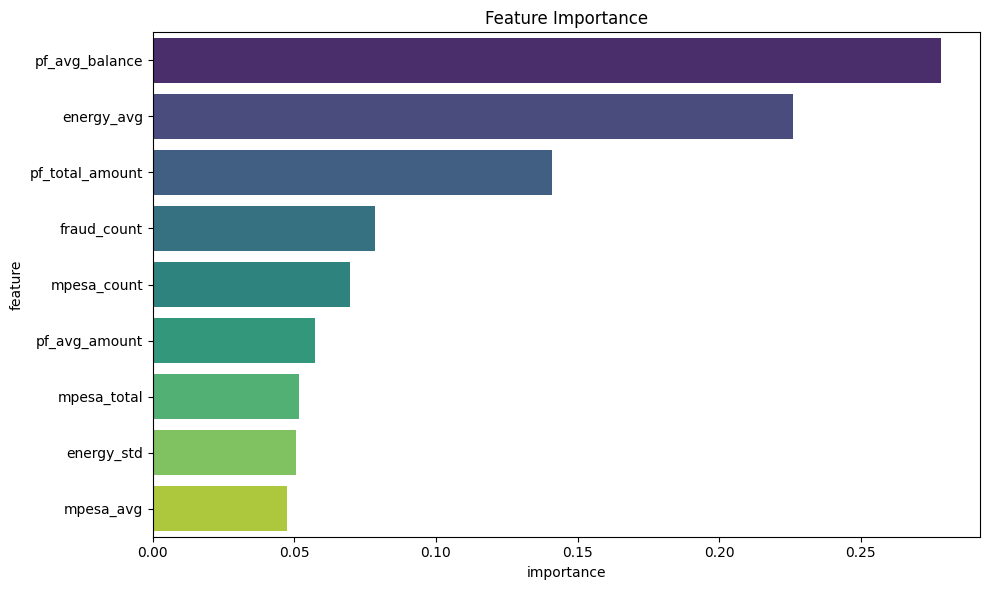

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Cleaned Dataset ===
df = pd.read_csv("/content/cleaned_credit_dataset.csv")

# === Simulate a Binary Target: is_creditworthy (just for prototyping) ===
# Criteria: Users with high personal finance balance + low fraud + high energy usage
df['is_creditworthy'] = (
    (df['pf_avg_balance'] > df['pf_avg_balance'].median()) &
    (df['fraud_count'] < 1) &
    (df['energy_avg'] > df['energy_avg'].median())
).astype(int)

# === Features & Target ===
X = df.drop(columns=['user_id', 'is_creditworthy'])
y = df['is_creditworthy']

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# === Model: Random Forest ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === Predictions & Evaluation ===
y_pred = model.predict(X_test)
print("✅ Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# === Feature Importance ===
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# === Plot Feature Importances ===
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette="viridis")
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [19]:
pip install tensorflow pandas scikit-learn matplotlib seaborn


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8051 - loss: 0.5730 - val_accuracy: 0.7500 - val_loss: 0.5908
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7236 - loss: 0.5824 - val_accuracy: 0.7500 - val_loss: 0.5635
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7801 - loss: 0.4975 - val_accuracy: 0.7500 - val_loss: 0.5411
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8324 - loss: 0.4772 - val_accuracy: 0.7500 - val_loss: 0.5224
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8343 - loss: 0.4345 - val_accuracy: 0.7500 - val_loss: 0.5068
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8761 - loss: 0.3826 - val_accuracy: 0.7500 - val_loss: 0.4934
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9158 - loss: 0.3647 - val_accuracy: 0.7500 - val_loss: 0.4823
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7967 - loss: 0.4273 - val_accuracy: 0.7500 - val_loss: 0.4718
Epoch 9/50

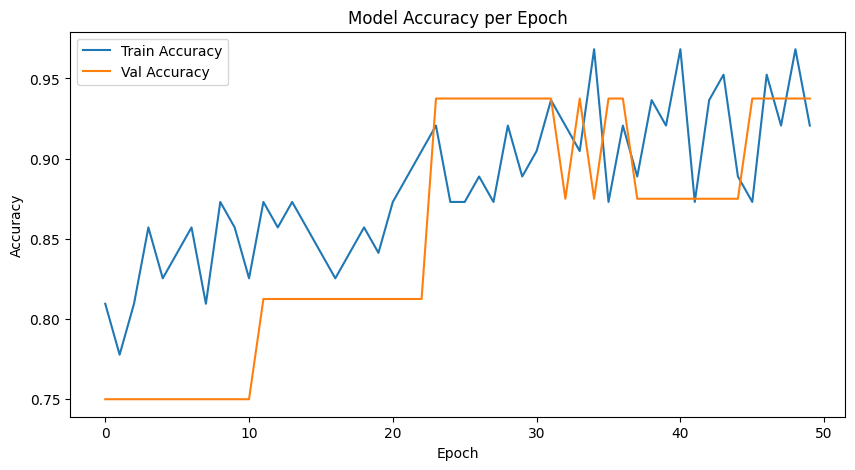

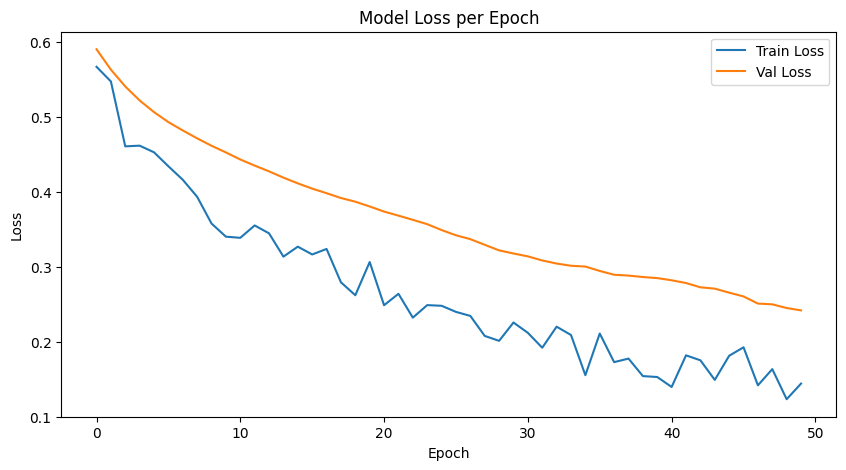

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


✅ Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.50      0.67      0.57         3

    accuracy                           0.85        20
   macro avg       0.72      0.77      0.74        20
weighted avg       0.87      0.85      0.86        20

✅ Confusion Matrix:
 [[15  2]
 [ 1  2]]
✅ Model saved to credit_model.h5


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# === Load Cleaned Dataset ===
df = pd.read_csv("/content/cleaned_credit_dataset.csv")

# === Simulate Target ===
df['is_creditworthy'] = (
    (df['pf_avg_balance'] > df['pf_avg_balance'].median()) &
    (df['fraud_count'] < 1) &
    (df['energy_avg'] > df['energy_avg'].median())
).astype(int)

# === Features and Target ===
X = df.drop(columns=['user_id', 'is_creditworthy'])
y = df['is_creditworthy']

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Normalize Features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Build Neural Network ===
model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary output

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# === Train the Model ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# === Plot Training Progress ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# === Evaluation ===
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
print("✅ Classification Report:\n", classification_report(y_test, y_pred))
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# === Optional: Save Model ===
model.save("/content/credit_model.h5")
print("✅ Model saved to credit_model.h5")


In [21]:
pip install streamlit pandas matplotlib seaborn fpdf


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.7 MB/s eta 0:00:00
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=27f1b14c9c207f010de5456e7703c3728ef9fa9fcdc402f5557e89b1c43f83c9
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [22]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
from io import BytesIO
import base64

# =====================
# STREAMLIT UI SETUP
# =====================

st.set_page_config(page_title="Alternative Credit Scoring App", layout="wide")
st.title("📊 Alternative Credit Scoring Engine")
st.markdown("Upload CSVs of your financial records to get your credit score based on non-traditional indicators like energy usage and mobile money.")

# =====================
# FILE UPLOAD
# =====================

uploaded_file = st.file_uploader("📁 Upload a CSV file with user financial data", type=["csv"])

if uploaded_file:
    df = pd.read_csv(uploaded_file)
    st.subheader("🔍 Preview of Uploaded Data")
    st.write(df.head())

    if 'user_id' not in df.columns:
        st.error("❌ The dataset must contain a `user_id` column.")
    else:
        # =====================
        # CUSTOM SCORING
        # =====================

        st.sidebar.title("⚙️ Scoring Weights (adjustable)")
        balance_weight = st.sidebar.slider("💰 Average Balance Weight", 0.0, 1.0, 0.4)
        fraud_weight = st.sidebar.slider("🚨 Fraud Count Weight", 0.0, 1.0, 0.3)
        energy_weight = st.sidebar.slider("⚡ Energy Usage Weight", 0.0, 1.0, 0.3)

        # Fill missing values
        df.fillna(0, inplace=True)

        # Scoring Function
        def custom_score(row):
            score = 0
            if 'pf_avg_balance' in row:
                score += balance_weight * min(row['pf_avg_balance'] / 10000, 1)
            if 'fraud_count' in row:
                score += fraud_weight * (1 - min(row['fraud_count'], 1))
            if 'energy_avg' in row:
                score += energy_weight * (1 if row['energy_avg'] > 300 else 0.5)
            return round(score, 2)

        df['credit_score'] = df.apply(custom_score, axis=1)

        st.success("✅ Credit scores computed successfully!")
        st.dataframe(df[['user_id', 'credit_score']].sort_values(by="credit_score", ascending=False))

        # =====================
        # VISUALIZATION
        # =====================

        st.subheader("📉 Credit Score Distribution")
        fig, ax = plt.subplots()
        sns.histplot(df['credit_score'], bins=20, kde=True, ax=ax)
        st.pyplot(fig)

        st.subheader("🚨 Low Score Users (Score < 0.5)")
        st.write(df[df['credit_score'] < 0.5])

        # =====================
        # PDF REPORT GENERATION
        # =====================

        st.subheader("🧾 Generate PDF Report for a User")

        selected_user = st.selectbox("Select User", df['user_id'].unique())

        def generate_pdf(user_data):
            pdf = FPDF()
            pdf.add_page()
            pdf.set_font("Arial", size=12)
            pdf.cell(200, 10, txt="User Credit Score Report", ln=True, align="C")
            pdf.ln(10)
            for k, v in user_data.items():
                pdf.cell(200, 10, txt=f"{k}: {v}", ln=True)
            return pdf

        if st.button("Generate PDF"):
            user_info = df[df['user_id'] == selected_user].iloc[0].to_dict()
            pdf = generate_pdf(user_info)

            # Save to in-memory buffer
            buffer = BytesIO()
            pdf.output(buffer)
            buffer.seek(0)
            b64 = base64.b64encode(buffer.read()).decode()
            href = f'<a href="data:application/pdf;base64,{b64}" download="{selected_user}_report.pdf">📥 Download PDF Report</a>'
            st.markdown(href, unsafe_allow_html=True)

        # =====================
        # M-PESA INTEGRATION PLACEHOLDER
        # =====================

        st.sidebar.markdown("---")
        st.sidebar.subheader("📡 M-Pesa API (Optional)")

        if st.sidebar.button("Simulate M-Pesa Connection"):
            st.sidebar.info("✅ M-Pesa API would connect here to pull transaction data.")
            st.sidebar.markdown("This requires Safaricom Daraja API setup.")


2025-07-30 14:48:45.483 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 14:48:45.487 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 14:48:46.066 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-30 14:48:46.069 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 14:48:46.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 14:48:46.076 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-30 14:48:46.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn